![Header.jpeg](../assets/banner_linreg.png)

# Analisis dan Prediksi Konsumsi Energi pada Bangunan Menggunakan Algoritma *Lasso Regression*

---

<h2>Daftar isi</h2>

- <a href=#bu>Business Understanding</a>
- <a href=#du>Data Understanding</a>
- <a href=#dp>Data Preparation</a>
- <a href=#ml>Modeling</a>
- <a href=#ev>Evaluation</a>
- <a href=#dy>Deployment</a>


<hr>


*<h2 id='bu'>Business Understanding</h2>*

Hands-On ini menggunakan algoritma Lasso Regression yang termasuk ke dalam regresi teregularisasi untuk memprediksi konsumsi energi pada bangunan dengan karakteristik tertentu. 

#### Data Source:
https://www.kaggle.com/datasets/govindaramsriram/energy-consumption-dataset-linear-regression

<hr>

*<h2 id='du'>Data Understanding</h2>*

#### Impor Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle

#### Impor Data

In [2]:
df = pd.read_csv("../data/train_energy_data.csv")

In [3]:
df.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,Residential,7063,76,10,29.84,Weekday,2713.95
1,Commercial,44372,66,45,16.72,Weekday,5744.99
2,Industrial,19255,37,17,14.30,Weekend,4101.24
3,Residential,13265,14,41,32.82,Weekday,3009.14
4,Commercial,13375,26,18,11.92,Weekday,3279.17


#### Informasi Kolom

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


- Building Type: Fitur kategoris yang mewakili tipe bangunan.

- Square Footage: Fitur numerik yang mewakili total luas persegi bangunan.

- Number of Occupants: Fitur numerik yang menunjukkan jumlah orang yang menempati bangunan.

- Appliances Used: Fitur numerik yang mewakili jumlah peralatan yang digunakan di dalam bangunan.

- Average Temperature: Fitur numerik yang mewakili suhu rata-rata bangunan atau area iklim (dalam Celsius).

- Day of Week t: Fitur kategoris yang mewakili apakah titik data sesuai dengan hari kerja atau akhir pekan.

- Energy Consumption: Variabel target numerik yang mewakili konsumsi energi bangunan dalam kWh (kilowatt-jam). Ini adalah nilainya

#### Statistik Deskriptif

In [5]:
df.describe(include="all")

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
count,1000,1000.000,1000.000000,1000.000000,1000.000000,1000,1000.000000
unique,3,NaN,NaN,NaN,NaN,2,NaN
top,Residential,NaN,NaN,NaN,NaN,Weekday,NaN
freq,347,NaN,NaN,NaN,NaN,507,NaN
mean,NaN,25462.388,48.372000,25.606000,22.611390,NaN,4166.252570
std,NaN,14294.554,29.061972,14.105166,7.139943,NaN,933.313064
min,NaN,560.000,1.000000,1.000000,10.050000,NaN,1683.950000
25%,NaN,13169.750,22.000000,13.000000,16.475000,NaN,3509.482500
50%,NaN,25477.000,47.000000,26.000000,22.815000,NaN,4175.730000
75%,NaN,37446.250,73.250000,38.000000,28.850000,NaN,4863.850000


In [6]:
def dist_obj_cols(feature: str):
    ax = sns.histplot(x=df[feature])

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + (p.get_width() / 2), p.get_height()), 
                    ha='center', va='bottom', fontsize=12)
    plt.show()

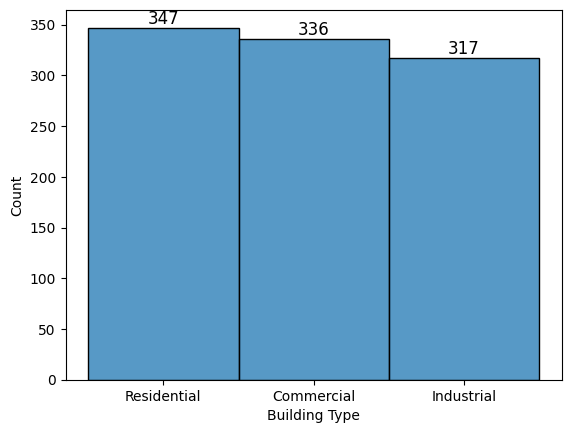

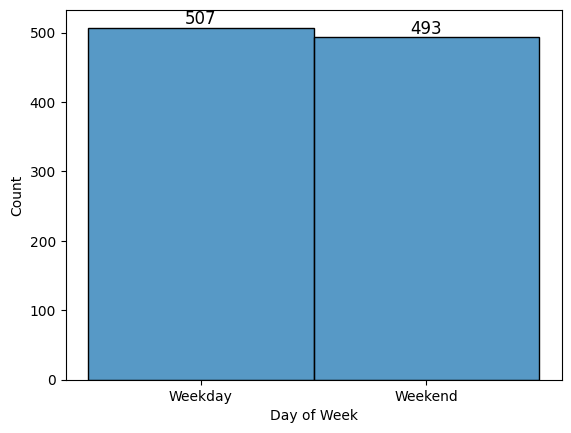

In [7]:
for x in df.columns:
    if df[x].dtype == "object":
        dist_obj_cols(x)

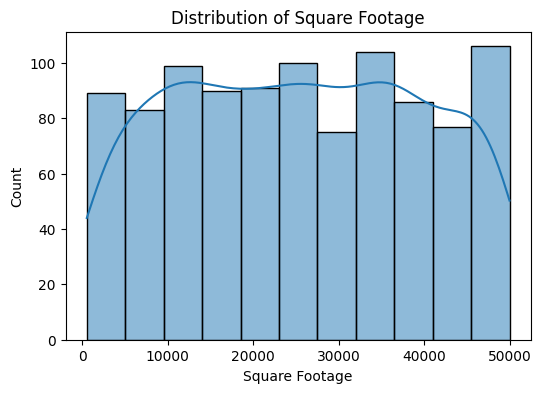

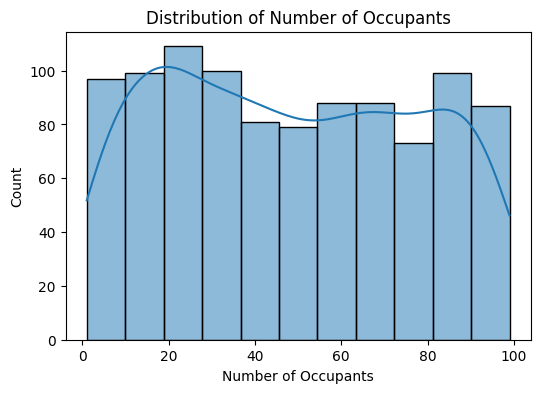

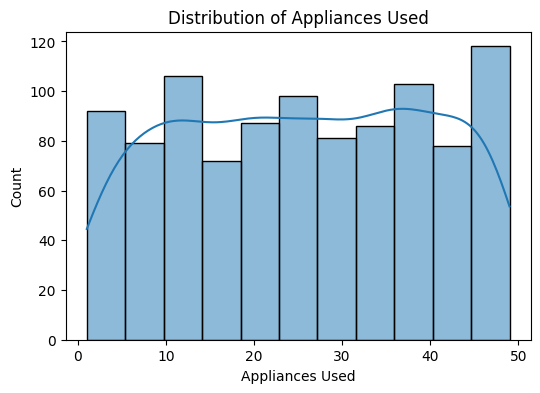

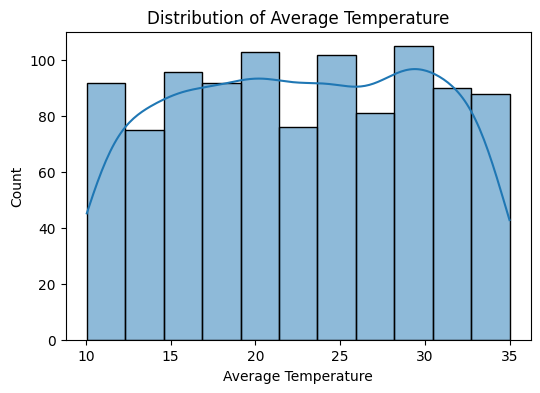

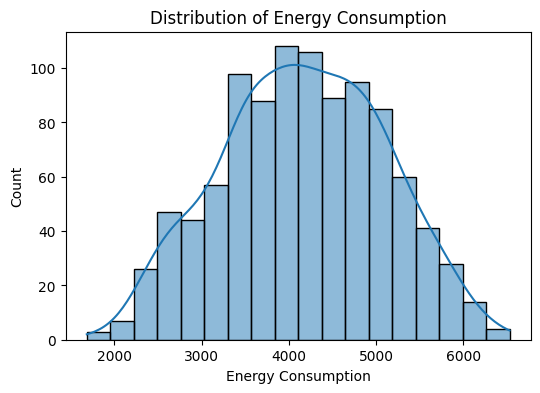

In [38]:
for x in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[x], kde=True)
    plt.title(f'Distribution of {x}')
    
plt.show()

<hr>

*<h2 id='du'>Data Preparation</h2>*

#### Cek Data Null

In [9]:
df.isna().sum()

Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

#### Cek Data Duplikat

In [10]:
df.duplicated().sum()

0

#### Cek Outlier

In [11]:
df_check_outlier = df.select_dtypes(exclude=["object"])

In [12]:
q1 = df_check_outlier.quantile(0.25)
q3 = df_check_outlier.quantile(0.75)
iqr = q3 - q1
low_bound = q1 - (1.5 * iqr)
up_bound = q3 + (1.5 * iqr)

outliers = ((df_check_outlier < low_bound) | (df_check_outlier > up_bound))
outliers.sum()

Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Energy Consumption     0
dtype: int64

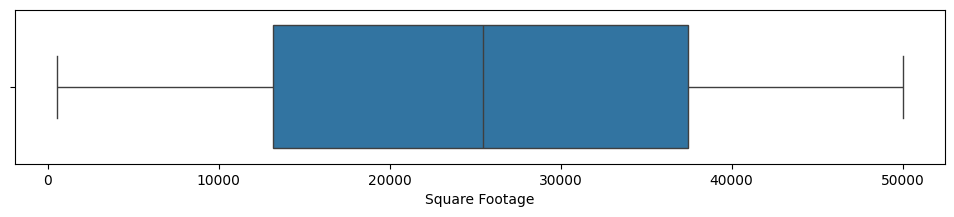

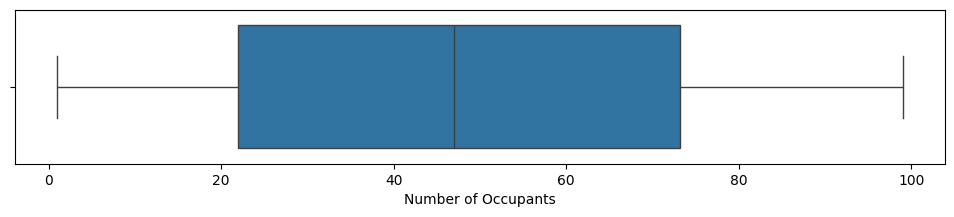

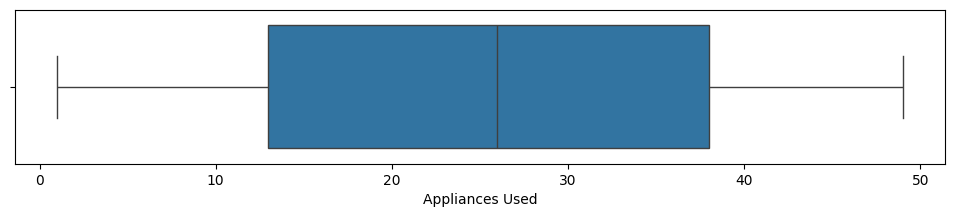

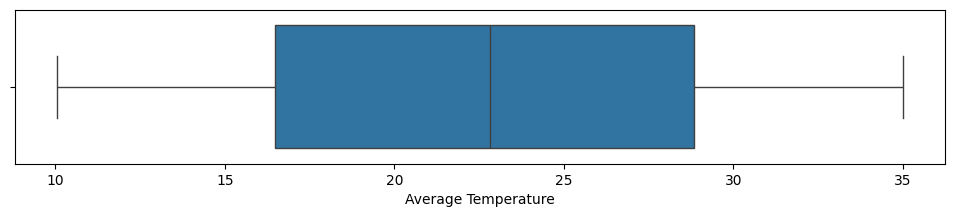

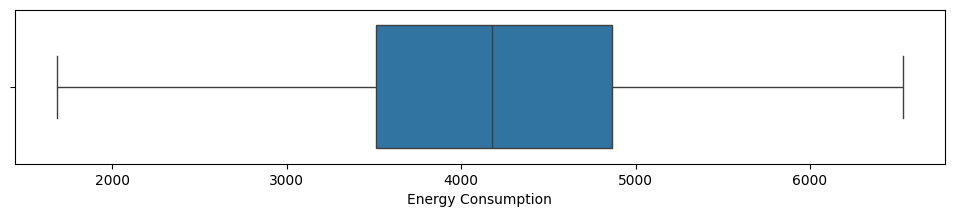

In [13]:
for x in df_check_outlier:
    plt.figure(figsize=(12, 2))
    sns.boxplot(data=df_check_outlier, x=x)

plt.show()

#### Encoding

In [14]:
def freq_enc_util(data, col: list):
    new_df = data.copy()
    list_freq = []
    for x in col:
        freq = (round(new_df[x].value_counts() / (len(new_df)), 3)).to_dict()
        list_freq.append(freq)
        new_df[x] = new_df[x].map(freq)
        
    return list_freq, new_df

In [15]:
list_freq_enc, new_df = freq_enc_util(df, col=df.select_dtypes(include=["object"]).columns)

In [16]:
list_freq_enc

[{'Residential': 0.347, 'Commercial': 0.336, 'Industrial': 0.317},
 {'Weekday': 0.507, 'Weekend': 0.493}]

In [17]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   float64
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   float64
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 54.8 KB


In [18]:
new_df = new_df.astype("float64")
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   float64
 1   Square Footage       1000 non-null   float64
 2   Number of Occupants  1000 non-null   float64
 3   Appliances Used      1000 non-null   float64
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   float64
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(7)
memory usage: 54.8 KB


In [19]:
new_df["Building Type"].value_counts()

Building Type
0.347    347
0.336    336
0.317    317
Name: count, dtype: int64

In [20]:
new_df["Day of Week"].value_counts()

Day of Week
0.507    507
0.493    493
Name: count, dtype: int64

In [21]:
new_df.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week,Energy Consumption
0,0.347,7063.0,76.0,10.0,29.84,0.507,2713.95
1,0.336,44372.0,66.0,45.0,16.72,0.507,5744.99
2,0.317,19255.0,37.0,17.0,14.30,0.493,4101.24
3,0.347,13265.0,14.0,41.0,32.82,0.507,3009.14
4,0.336,13375.0,26.0,18.0,11.92,0.507,3279.17


#### Cek Korelasi

<Axes: >

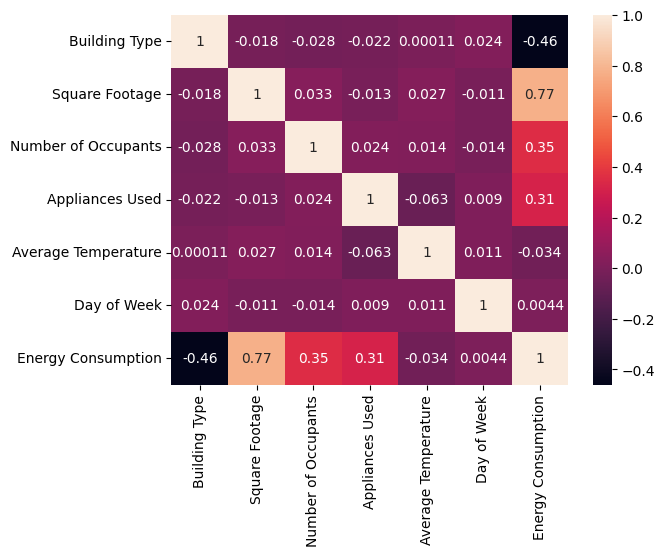

In [22]:
sns.heatmap(new_df.corr(), annot=True)

#### Splitting Data

In [23]:
X = new_df.iloc[:, :-1]
y = new_df.iloc[:, -1]

In [24]:
X

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week
0,0.347,7063.0,76.0,10.0,29.84,0.507
1,0.336,44372.0,66.0,45.0,16.72,0.507
2,0.317,19255.0,37.0,17.0,14.30,0.493
3,0.347,13265.0,14.0,41.0,32.82,0.507
4,0.336,13375.0,26.0,18.0,11.92,0.507
...,...,...,...,...,...,...
995,0.347,14419.0,68.0,44.0,23.95,0.493
996,0.317,12194.0,7.0,22.0,14.67,0.493
997,0.336,39562.0,88.0,20.0,32.18,0.507
998,0.347,8348.0,67.0,37.0,16.48,0.493


In [25]:
y

0      2713.95
1      5744.99
2      4101.24
3      3009.14
4      3279.17
        ...   
995    3661.21
996    3546.34
997    5147.21
998    3244.98
999    3423.63
Name: Energy Consumption, Length: 1000, dtype: float64

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
X_train.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week
29,0.347,27072.0,12.0,30.0,32.89,0.493
535,0.336,9874.0,5.0,19.0,20.65,0.507
695,0.317,22427.0,8.0,13.0,26.21,0.507
557,0.347,30129.0,29.0,33.0,23.73,0.493
836,0.336,16350.0,14.0,38.0,18.39,0.507


In [28]:
X_test.head()

,Building Type,Square Footage,Number of Occupants,Appliances Used,Average Temperature,Day of Week
521,0.336,40192.0,23.0,23.0,30.00,0.493
737,0.347,8406.0,25.0,36.0,19.48,0.507
740,0.317,47719.0,92.0,7.0,32.82,0.493
660,0.336,37435.0,26.0,35.0,21.64,0.507
411,0.336,11331.0,47.0,43.0,21.10,0.493


#### Skalasi Data

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
X_train_scaled

array([[ 1.06341773,  0.12018396, -1.21478   ,  0.3210255 ,  1.44398132,
        -1.03046381],
       [ 0.17098248, -1.07490811, -1.45338153, -0.46676713, -0.27042938,
         0.97043679],
       [-1.37049658, -0.20259792, -1.35112373, -0.89647221,  0.50833888,
         0.97043679],
       ...,
       [ 0.17098248,  0.13866834, -0.36263171,  1.68175823,  1.47899788,
         0.97043679],
       [-1.37049658,  0.12136529,  0.72811811, -0.03706206,  0.94534553,
         0.97043679],
       [ 0.17098248, -1.41568794, -0.90800662, -0.61000216,  1.02938527,
        -1.03046381]])

In [31]:
X_test_scaled

array([[ 0.17098248,  1.03189508, -0.83983475, -0.18029709,  1.0391899 ,
        -1.03046381],
       [ 1.06341773, -1.1769197 , -0.77166289,  0.75073057, -0.43430687,
         0.97043679],
       [-1.37049658,  1.55494765,  1.51209454, -1.32617728,  1.43417668,
        -1.03046381],
       ...,
       [ 0.17098248, -1.51137592,  1.37575082,  1.10881813, -0.04352208,
        -1.03046381],
       [ 1.06341773,  1.07324174, -0.43080357, -1.54102981, -1.20327049,
         0.97043679],
       [-1.37049658,  0.87123379, -0.4648895 , -1.03970723, -1.4932076 ,
         0.97043679]])

<hr>

*<h2 id='ml'>Modeling</h2>*

In [32]:
lasso_cv = LassoCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
lasso_cv.fit(X_train_scaled, y_train)

print("Best alpha:", lasso_cv.alpha_)

Best alpha: 0.01


In [33]:
lasso_model = Lasso(alpha=0.01)
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [34]:
y_pred = lasso_model.predict(X_test_scaled)

In [35]:
res = pd.DataFrame({"Actual": y_test, "Pred": y_pred})
res.sample(10)

,Actual,Pred
644,4612.22,4640.616882
66,3403.93,3325.180702
63,2968.20,2880.868790
867,3350.06,3405.600298
652,4495.21,4413.596470
829,5393.95,5427.128010
294,3386.72,3431.625901
845,4378.55,4429.113129
583,4085.95,4142.333729
23,3930.14,3841.447399


<hr>

*<h2 id='ml'>Evaluation</h2>*

In [36]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 3969.5561
R² Score: 0.9951


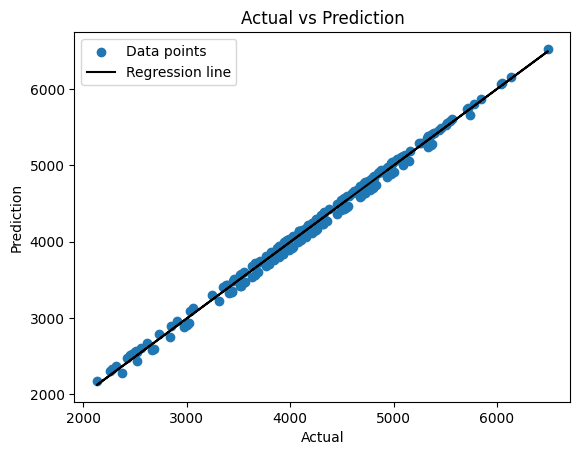

In [37]:
plt.scatter(y_test, y_pred, label='Data points')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='black', label='Regression line')

plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Actual vs Prediction")
plt.legend()

plt.show()

<hr>

*<h2 id='ml'>Deployment</h2>*



---


Copyright © 2025 by DGX Development Team, Gunadarma University


https://www.hpc-hub.gunadarma.ac.id/